# Natural language processing: spam detection

In [9]:
import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## 1. Data loading

### 1.1. Load the data

In [10]:
# Read csv file into dataframe
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')

### 1.2. Inspect the data

In [11]:
data_df.head()


,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [12]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [13]:
data_df.isnull().sum()




url        0
is_spam    0
dtype: int64

In [29]:
labels = data_df['is_spam']
features = data_df.drop('is_spam', axis=1)  

encoded_labels = labels.apply(lambda x: 1 if x else 0).astype(int)

training_features, testing_features, encoded_training_labels, encoded_testing_labels = train_test_split(features, encoded_labels, test_size=0.25, random_state=42)

In [30]:
def preprocess_text(text):

    # Remove any character that is not a letter (a-z) or white space ( )
    text=re.sub(r'[^a-z ]', ' ', text)
    
    # Remove white spaces
    text=re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text=re.sub(r'\^[a-zA-Z]\s+', ' ', text)

    # Multiple white spaces into one
    text=re.sub(r'\s+', ' ', text.lower())

    # Remove tags
    text=re.sub('&lt;/?.*?&gt;',' &lt;&gt; ', text)

    # Remove 'http', 'https' and 'www'
    # text=re.sub('https', '', text)
    # text=re.sub('http', '', text)
    text=re.sub('www', '', text)

    return text.split()

training_features['url']=training_features['url'].apply(preprocess_text)
training_features.head()

,url
1064,"[https, en, wikipedia, org, wiki, eter, amborn..."
662,"[https, flickr, com, photos, websummit]"
480,"[https, nbcnews, com, business, economy, s, ec..."
2136,"[https, nytimes, com, technology, uber, postma..."
2702,"[https, mashable, com, article, amazon, prime,..."


In [31]:
download('wordnet')
lemmatizer=WordNetLemmatizer()

download('stopwords')
stop_words=stopwords.words('english')

def lemmatize_text(words, lemmatizer=lemmatizer):
    tokens=[lemmatizer.lemmatize(word) for word in words]
    tokens=[word for word in tokens if word not in stop_words]
    tokens=[word for word in tokens if len(word) > 3]
    return tokens

training_features['url']=training_features['url'].apply(lemmatize_text)
training_features.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/taylorclements/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taylorclements/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url
1064,"[http, wikipedia, wiki, eter, amborn, ilson]"
662,"[http, flickr, photo, websummit]"
480,"[http, nbcnews, business, economy, economy, sh..."
2136,"[http, nytimes, technology, uber, postmates, o..."
2702,"[http, mashable, article, amazon, prime, video..."


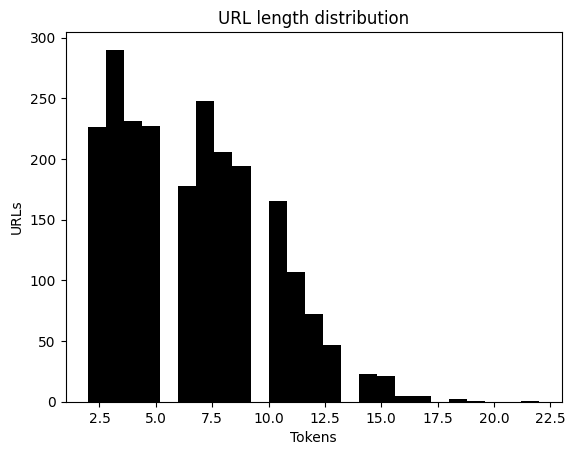

URL length mean: 7 tokens
URL length min: 2 tokens
URL length max: 22 tokens


In [17]:

# Get the lengths (in tokens)
lengths=[len(url) for url in training_features['url'].tolist()]

# Add it back to the data as a new feature
training_features['url_len']=lengths

plt.title('URL length distribution')
plt.xlabel('Tokens')
plt.ylabel('URLs')
plt.hist(lengths, bins=25, color='black')
plt.show()

print(f'URL length mean: {mean(lengths):.0f} tokens')
print(f'URL length min: {min(lengths):.0f} tokens')
print(f'URL length max: {max(lengths):.0f} tokens')

In [18]:
# Add the labels back temporarily, so we can remove the corresponding label with url
training_features['target']=encoded_training_labels
training_features=training_features[training_features['url_len'] > 0]

# Re-separate the features and labels
encoded_training_labels=training_features['target']
training_features.drop(['target'], axis=1, inplace=True)

In [19]:
training_features[training_features['url_len'] > 15]

,url,url_len
2984,"[http, canopygrowth, investor, news, release, ...",18
2710,"[http, ohio, news, ohio, university, professor...",16
236,"[http, judiciary, senate, press, release, chai...",17
2924,"[http, washingtonpost, local, public, safety, ...",16
2244,"[http, washingtonpost, national, security, rus...",18
2944,"[http, reuters, article, russia, putin, vote, ...",17
2621,"[http, blog, microsoft, blog, microsoft, launc...",17
248,"[http, tulsaworld, news, trump, tulsa, preside...",17
50,"[http, hopkinsmedicine, news, newsroom, news, ...",16
1060,"[http, king, article, news, local, protest, ac...",16


In [20]:
# Extract the tokenized URLs and join the individual lists
tokens_list=training_features['url']
tokens_list=[' '.join(tokens) for tokens in tokens_list]

# Vectorize the URLs using TF-IDF
vectorizer=TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
encoded_training_features=vectorizer.fit_transform(tokens_list).toarray()

# Get the words from the vector model
feature_names=vectorizer.get_feature_names_out()

# Convert the training data word counts back into a dataframe
encoded_training_features=pd.DataFrame(encoded_training_features, columns=feature_names)
print(f'Encoded features shape: {encoded_training_features.shape}')

Encoded features shape: (2249, 475)


In [21]:
encoded_training_features.head()


,abcnews,abortion,account,action,activist,administration,advertising,afghanistan,amazon,america,...,wwdc,yduq,year,york,young,youre,youtu,youtube,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503753,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


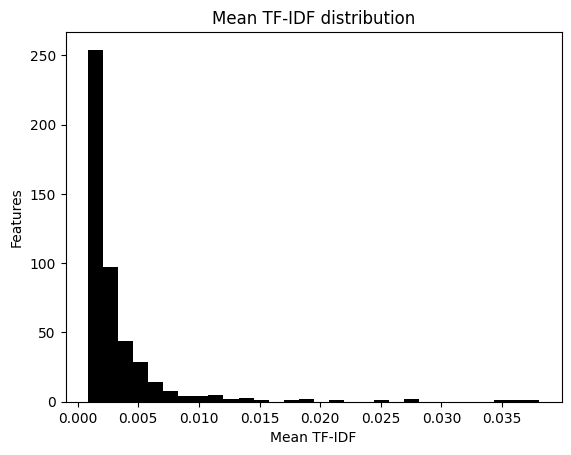

In [22]:
feature_means=encoded_training_features.mean().tolist()

plt.title('Mean TF-IDF distribution')
plt.xlabel('Mean TF-IDF')
plt.ylabel('Features')
plt.hist(feature_means, bins=30, color='black')
plt.show()

In [23]:
cv_folds=7

# Instantiate the support vector machine classifier with defaults
baseline_model=SVC(class_weight='balanced')

# Cross-validate the default model on the encoded training data
scores=cross_val_score(
    baseline_model,
    encoded_training_features,
    encoded_training_labels,
    cv=cv_folds,
    n_jobs=-1
)

# Save the baseline cross-validation scores for later
cross_val_scores={
    'Model': ['Baseline']*cv_folds,
    'Score': list(scores)
}

print(f'Cross validation accuracy: {np.mean(scores)*100:.1f}+/-{np.std(scores)*100:.1f}%')

Cross validation accuracy: 94.0+/-1.2%


In [24]:
hyperparameters = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

# Instantiate a new model
model=SVC(class_weight='balanced')

# Set up the grid search
grid=GridSearchCV(model, hyperparameters, scoring='accuracy', cv=cv_folds, n_jobs=-1)

# Run the search
optimization_results=grid.fit(encoded_training_features, encoded_training_labels)

print(f'Best hyperparameters: {grid.best_params_}')

Best hyperparameters: {'C': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}


In [25]:
# Cross-validate the model with the winning hyperparameters
optimized_model=SVC(**grid.best_params_, class_weight='balanced')

# Cross-validate the optimized model on the encoded training data
scores=cross_val_score(
    optimized_model,
    encoded_training_features,
    encoded_training_labels,
    cv=cv_folds,
    n_jobs=-1
)

# Save the optimized cross-validation scores for later
cross_val_scores['Model'].extend(['Optimized']*cv_folds)
cross_val_scores['Score'].extend(scores)

print(f'Cross validation accuracy: {np.mean(scores)*100:.1f}+/-{np.std(scores)*100:.1f}%')

Cross validation accuracy: 94.4+/-1.2%


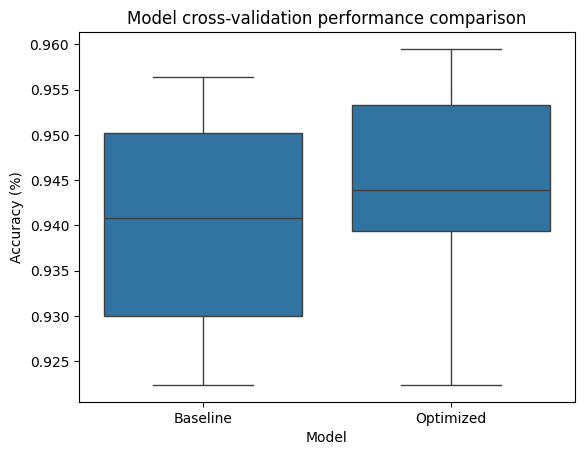

In [26]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.show()

In [27]:
# Clean up the text
testing_features['url']=testing_features['url'].apply(preprocess_text)
testing_features['url']=testing_features['url'].apply(lemmatize_text)

# Get the lengths (in tokens)
lengths=[len(url) for url in testing_features['url'].tolist()]

# Add it back to the data as a new feature
testing_features['url_len']=lengths

# Exclude urls shorter than 15
testing_features[testing_features['url_len'] > 0]

# Extract the tokenized URLs and join the individual lists
tokens_list=testing_features['url']
tokens_list=[' '.join(tokens) for tokens in tokens_list]

encoded_testing_features=vectorizer.transform(tokens_list).toarray()

# Convert the testing data word counts back into a dataframe
encoded_testing_features=pd.DataFrame(encoded_testing_features, columns=feature_names)
print(f'Encoded features shape: {encoded_testing_features.shape}')

Encoded features shape: (750, 475)


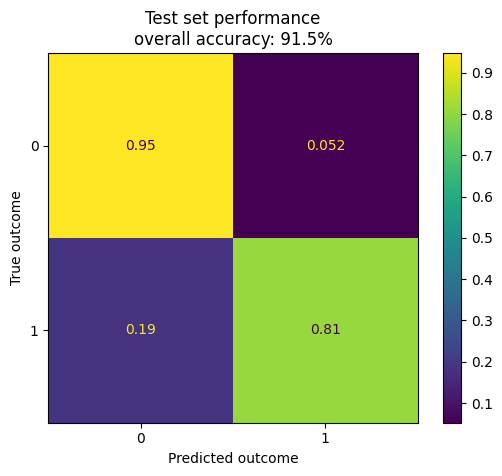

In [28]:
optimized_model.fit(encoded_training_features, encoded_training_labels)
predictions=optimized_model.predict(encoded_testing_features)

accuracy=accuracy_score(predictions, encoded_testing_labels)*100

# Plot the confusion matrix
cm=confusion_matrix(encoded_testing_labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()